Group Members:

Name: `Sayeh Jarollahi` \
Student ID (matriculation number): `7073520` \
Email: `saja00006@stud.uni-saarland.de` 

Name: `Mahsa Amani` \
Student ID (matriculation number): `7064006` \
Email: `maam00002@stud.uni-saarland.de`

# Exercise 2.3 - Eigencats (3.5pts)

<figure>
<a id="examples"><center><img src="imgs/eigencats.png" style="width:50%"/></center></a>
<figcaption align = "center"> Figure 1: Some examples of eigencats. </figcaption>
</figure>

In this assignment you will compute *eigencats* of a [cat dataset](https://github.com/bioramble/pca/blob/master/cat.csv). You can find a paper on a similar approach applied to human faces [here](http://engr.case.edu/merat_francis/eecs490f04/References/Face%20Recognition/LD%20Face%20analysis.pdf). Note that the linked resources are only here to provide additional background knowledge and you do not need to understand them in any detail to complete this assignment. In general, *eigencats* can be seen as linear combinations of cat faces from the dataset, from which the original faces can be reconstructed. You can find some examples in [Figure 1](#examples). For general datasets, this approach of finding compressed features is also known as Principal Components Analysis (PCA), which will be covered in detail in upcoming lectures. To complete this assignment, however, the material covered up to Chapter 3 is sufficient. 

In [1]:
import sys
assert sys.version_info >= (3, 6), "This notebook requires python version >= 3.6 to support type hints."

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [3]:
def plot_cats(imgs: np.ndarray, n: int, start:int=0) -> None:
    """Plots the first n images from imgs, starting from start
    args:
        imgs: a numpy array of shape (N, 64, 64) containing N 64x64 images
        n: number of images to plot
    """
    assert imgs.shape[0] >= n, f"imgs array must contain at least {n} images"
    assert imgs.ndim == 3, f"imgs array must be of shape (N, H, W). If you passed flattened images, reshape them first."
    assert imgs.shape[1:] == (64, 64), f"Images must be of dimension (64, 64) not {imgs.shape[1:]}."
    fig, axes = plt.subplots(1, n)
    if n == 1:
        axes.imshow(imgs[start])
        axes.set_axis_off()
    else:
        for i in range(n):
            axes[i].imshow(imgs[start+i])
            axes[i].set_axis_off()
    plt.show()

The cat faces are stored as a numpy array and are loaded by executing the cell below. Make sure to place the file `cats.npy` that comes with the assignment in the same folder as this notebook.

In [4]:
cats = np.load('cats.npy')
cats.shape

(80, 64, 64)

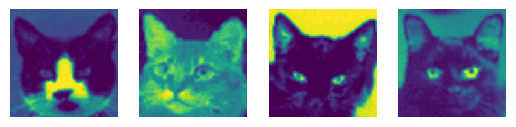

In [5]:
plot_cats(cats, 4)

## Exercise 2.3.1 - Preprocess (0.5pts)
First, calculate the average of all the cats images in the dataset to find the mean cat. Then, mean center the dataset by subtracting the mean cat from all images. For reference, the mean cat should look as in [Figure 2](#meanface). Lastly, flatten each image into a vector. After preprocessing, your dataset should contain 80 4096-dimensional vectors.

<figure>
<a id="examples"><center><img src="imgs/meancat.png" style="width:15%"/></center></a>
<figcaption align = "center"> Figure 2: Mean cat. </figcaption>
</figure>

In [6]:
def preprocess(cats: np.ndarray) -> np.ndarray:
    """Reshapes each cat image into a 1D vector and column-centers them to have mean 0."""  
    cats = cats.reshape(cats.shape[0], -1)
    mean_cats = cats.mean(axis=0)
    return cats - mean_cats

In [7]:
zero_mean_cats = preprocess(cats)
zero_mean_cats.shape

(80, 4096)

## Exercise 2.3.2 - EVD (1pt)
Compute the covariance matrix of the preprocessed cat faces using the formula $\text{Var}[\boldsymbol{X}] = \frac{1}{m - 1} \boldsymbol{X}^T \boldsymbol{X}$, where $\boldsymbol{X} \in \mathbb{R}^{m\times n}$, $m$ is the number of images and $n$ the number of features ($64 \times 64 = 4096$). Afterwards, find its eigenvectors ordered in descending order by their corresponding eigenvalues. You can use `sort_eigvectors` to do the sorting. Afterwards, plot the first four eigencats.

**Note:** If you use numpy, you will need to use `np.linalg.eigh` instead of `np.linalg.eig` to compute the eigendecomposition to avoid running into numerical issues. 

In [8]:
def sort_eigvectors(eigvalues: np.ndarray, eigvectors: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Sorts eigenvectors according to their corresponding eigenvalues. The input is expected to be the result of np.linalg.eigh.""" 
    idx = eigvalues.argsort()[::-1]
    eigvalues = eigvalues[idx] 
    eigvectors = eigvectors[:, idx]
    return eigvalues, eigvectors

In [10]:
def eigencats_evd(cat_vectors: np.ndarray) -> np.ndarray:
    cov_matrix = (1 / (cat_vectors.shape[0] - 1)) * cat_vectors.T @ cat_vectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_eigenvalues, sorted_eigenvectors = sort_eigvectors(eigenvalues, eigenvectors)
    return sorted_eigenvectors


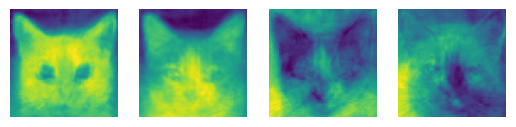

In [56]:
sorted_eigenvectors = eigencats_evd(zero_mean_cats)
cats = np.zeros((4, 64, 64))
for i in range(4):
    eigencat = sorted_eigenvectors[:, i].reshape(64, 64)
    cats[i] = eigencat
plot_cats(cats, 4)

## Exercise 2.3.3 - SVD (0.5pt)
Eigencats can also be computed using a singular value decomposition of the data matrix. Complete `eigencats_svd` by computing a singular value decomposition and returning the right singular values of the data matrix. Again, plot the first four eigencats.

In [18]:
def eigencats_svd(cats_vectors: np.ndarray) -> np.ndarray:
    U, S, Vt = np.linalg.svd(cats_vectors)
    return Vt

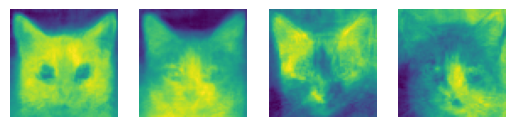

In [53]:
eigencats_imgs_svd = eigencats_svd(zero_mean_cats)
cats_svd = np.zeros((4, 64, 64))
for i in range(4):
    eigencat = eigencats_imgs_svd[i, :].reshape(64, 64)
    cats_svd[i] = eigencat
plot_cats(cats_svd, 4)

**Note**: The brightness values for some images might be inverted compared to the examples in [Figure 1](#examples) or those computed using the EVD. This is due to different algorithms used under the hood and you don't need to worry about it.

## Exercise 2.3.4 - Reconstruction (1pt)
Reconstruct the cats in the dataset with varying levels of accuracy. Use the SVD for this and vary the accuracy by including more or fewer singular values. You can do this by setting more or fewer singular values inside the diagonal matrix $\boldsymbol{D}$ to zero. Plot the first four cats in the dataset using 10, 40 and 80 singular values. What do you notice?

In [49]:
def reconstruct(cats: np.ndarray, num_singular_values: int) -> np.ndarray:
    U, S, Vt = np.linalg.svd(cats)
    
    S_reduced = np.zeros((U.shape[1], Vt.shape[0]))
    np.fill_diagonal(S_reduced, S[:num_singular_values])

    reconstructed_cats = (U @ S_reduced) @ Vt
    return reconstructed_cats

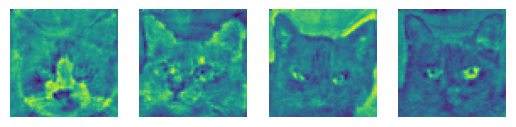

In [50]:
reconstruced_cats = reconstruct(zero_mean_cats, 10)
cats_svd = np.zeros((10, 64, 64))
for i in range(10):
    eigencat = reconstruced_cats[i, :].reshape(64, 64)
    cats_svd[i] = eigencat
plot_cats(cats_svd, 4)

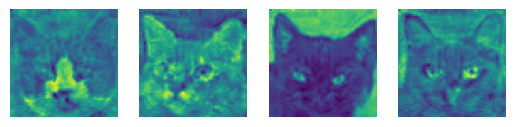

In [51]:
reconstruced_cats = reconstruct(zero_mean_cats, 40)
cats_svd = np.zeros((10, 64, 64))
for i in range(10):
    eigencat = reconstruced_cats[i, :].reshape(64, 64)
    cats_svd[i] = eigencat
plot_cats(cats_svd, 4)

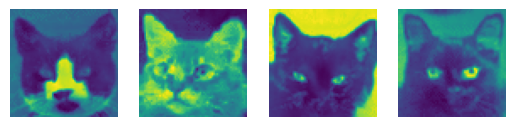

In [52]:
reconstruced_cats = reconstruct(zero_mean_cats, 80)
cats_svd = np.zeros((10, 64, 64))
for i in range(10):
    eigencat = reconstruced_cats[i, :].reshape(64, 64)
    cats_svd[i] = eigencat
plot_cats(cats_svd, 4)

### What do you see?
As we increase the number of singular values used in the reconstruction, the resolution and accuracy of images increase. This is caused by the fact that when we decrease the number of singular values, we are losing some informations about the values in the actual image. 

## Exercise 2.3.5 - Quiz (0.5pts)
1. Why are the results of exercise 2.3.2 and 2.3.3 the same? <br>
The both methods are trying to find the maximum variance in the data. In the first part, the matrix $X$ is decomposed as $XX^T = VAV^T$ where $V$ contains the eigenvectors. In this case, rows of $V$ find the directions of maximum variance in the data. In the SVD, We have somehow the same actions where $V$ is the right singular vectors. Therefore, both of these algorithms reach to the same output. 

2. (Optional) You may have noticed that the computation using the singular value decomposition was much faster than the eigenvalue decomposition.
   Why is this the case?

   In the eigenvalue decomposition, first we have to compute the covariance matrix which is time consuming. Additionally, we have to sort the eigenvectors basede on the eigenvalues in the function mentioned above. Hoever, in the SVD all the comoputation is in the function itself and non of these computations are needed. Also, typically numpy computes as efficient as it can be. Finally, the SVD decomposition is numerically more stable, so there is no concerns regarding that problem. 

